<a href="https://colab.research.google.com/github/Uditsingh7/Machine_Learning_Projects/blob/main/Unsupervised_Learning_Project_K_Means_%2B_Hierarchical_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Project Title and Business Problem

Customer Segmentation with K-Means and Hierarchical Clustering for Retail/Mall Analytics

Goal: Segment mall customers based on demographic and spending behavior to enable:

Targeted campaigns for high-value and at-risk segments.

Personalized offers and optimized retention budgets.

Better merchandising and store experience decisions.

Data: Mall Customers dataset with 200 customers and five fields, including Annual Income and Spending Score

In [10]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python")

Skipping, found downloaded files in "./customer-segmentation-tutorial-in-python" (use force=True to force download)


In [22]:
# @title Notebook Setup

# Cell: Imports and global settings
import os  # For interacting with the operating system (e.g., file paths)
import json  # For reading/writing JSON formatted data
import joblib  # For saving and loading Python objects efficiently (e.g., models)

import numpy as np  # Fundamental package for numerical computing with arrays
import pandas as pd  # Data manipulation and analysis, tabular data handling
import matplotlib.pyplot as plt  # Core plotting library for static visualizations
import seaborn as sns  # Statistical data visualization built on matplotlib with nicer default styles

# sklearn modules for data preprocessing and clustering
from sklearn.compose import ColumnTransformer  # Apply different transformations to different columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Scaling numeric data and encoding categorical variables
from sklearn.pipeline import Pipeline  # Chain multiple data processing steps sequentially
from sklearn.impute import SimpleImputer  # Handle missing data by imputing values (mean, median, mode etc.)
from sklearn.decomposition import PCA  # Dimensionality reduction technique (Principal Component Analysis)
from sklearn.cluster import KMeans, AgglomerativeClustering  # Unsupervised clustering algorithms (partitioning and hierarchical)
from sklearn.metrics import silhouette_score  # Metric to evaluate clustering quality (cohesion & separation)

from scipy.cluster.hierarchy import dendrogram, linkage  # Functions to perform hierarchical clustering and visualize as dendrogram

# Set seaborn style for better plot aesthetics (white grid background) and notebook-friendly context
sns.set(style="whitegrid", context="notebook")

# Configure pandas to display floats with 3 decimal places for better readability in outputs
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')

# Fixed random seed to ensure reproducibility of results
RANDOM_STATE = 42

In [23]:
# @title Data Loading and Context

# Cell: Load dataset

df = pd.read_csv("/content/customer-segmentation-tutorial-in-python/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [24]:
# Cell: Inspect structure and types
df.info()
df.describe(include='all')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


**Notes:**

Spending Score is a mall-assigned score from 1–100 indicating purchasing behavior.

No missing values are typical in common Kaggle copies, but always confirm.



In [ ]:
# @title Problem Framing and Why Clustering

Clustering segments customers without labels to uncover natural groups by income/spending/demographics.

**Outcomes:**

Identify high-spend/high-income “premium” clusters for loyalty programs.

Find low-income/high-spend segments potentially responding to discounts.

Avoid one-size-fits-all marketing, reduce CAC, and improve ROI.

**Data Preprocessing Plan**

Remove identifiers not useful for clustering (CustomerID).

Handle missing values (imputer).

Encode categorical variables (Gender).

Scale numeric variables to prevent scale dominance.

Keep preprocessing reproducible via Scikit-learn Pipelines.

In [25]:
# Cell: Define features and preprocessing

df_raw = df.copy()  # Create a copy of original dataframe to preserve raw data

# Identify and drop ID-like columns which don't carry predictive info (e.g., customer IDs)
id_cols = [c for c in df.columns if c.lower() in ["customerid", "id", "customer_id"]]
df = df.drop(columns=id_cols, errors='ignore')  # Drop safely, ignore if not found

# Separate columns by data type: categorical (object) and numerical (numbers)
cat_cols = [c for c in df.select_dtypes(include=['object']).columns]  # Categorical features
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns]  # Numerical features

# Define preprocessing pipeline for categorical features:
# - Impute missing values with the most frequent category (mode)
# - Encode categories into binary (one-hot encoding), ignoring unseen categories in new data
cat_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categorical values with mode
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # Convert categories to numeric columns
])

# Define preprocessing pipeline for numerical features:
# - Impute missing values with median to reduce influence of outliers
# - Scale features to zero mean and unit variance for better model performance
num_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Fill missing numerical values with median
    ("scaler", StandardScaler())  # Standardize numeric features
])

# Combine both preprocessing pipelines into a single transformer,
# applying the numeric pipeline to numeric columns and categorical pipeline to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_preprocess, num_cols),
        ("cat", cat_preprocess, cat_cols)
    ],
    remainder="drop"  # Drop any columns not specified (if any)
)

# Fit the preprocessor to the data and transform it into a numeric numpy array ready for modeling
X = preprocessor.fit_transform(df)

# Generate the list of feature names after transformation:
# - Original numeric column names remain the same
# - One-hot encoded categorical columns get expanded into multiple columns, each named with original column + category
feature_names = (
    list(num_cols)
    + list(preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols))
)

# Convert the transformed numpy array back into a pandas DataFrame for easier inspection
X_df = pd.DataFrame(X, columns=feature_names)

X_df.head()  # Display the first few rows of the processed dataset


,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,-1.425,-1.739,-0.435,0.000,1.000
1,-1.281,-1.739,1.196,0.000,1.000
2,-1.353,-1.701,-1.716,1.000,0.000
3,-1.138,-1.701,1.040,1.000,0.000
4,-0.563,-1.663,-0.396,1.000,0.000


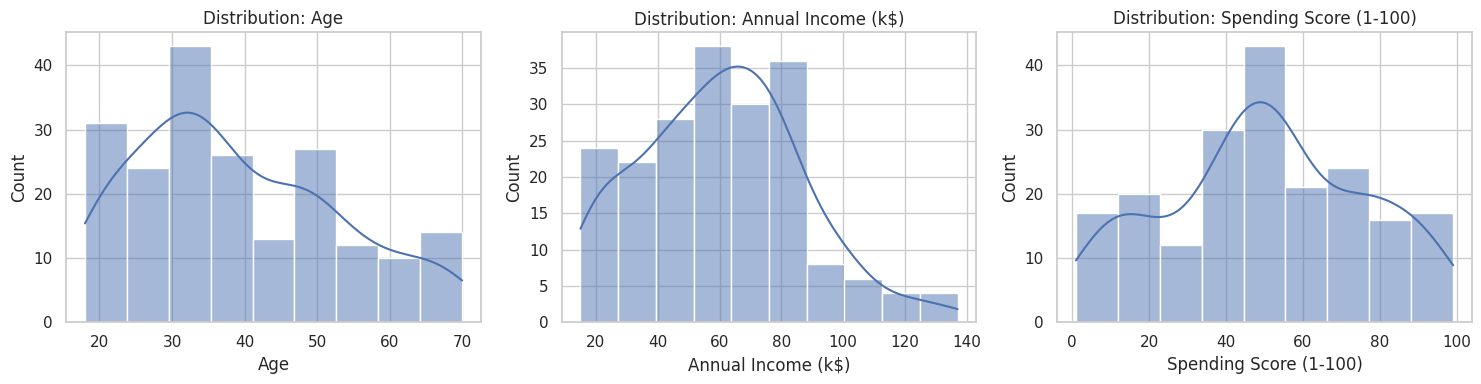

In [26]:
# @title Exploratory Data Analysis (EDA)

##Understand distributions, relationships,
##and correlations to inform clustering features and interpretation

# Cell: Univariate distributions
fig, axes = plt.subplots(1, len(num_cols), figsize=(5*len(num_cols), 4))
if len(num_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    ax.set_title(f"Distribution: {col}")
plt.tight_layout()
plt.show()

# Histograms show counts in bins, but the edges can be jagged or misleading based on bin width.
# KDE gives a smooth curve that shows trends or patterns more clearly.
# It makes it easier to spot peaks (modes), valleys, or the overall distribution shape


# If the blue line peaks at around age 30, it means many people are around that age.
# If the line is flat, the data is spread out evenly.
# If it has multiple peaks, it means the data has multiple common values (clusters).


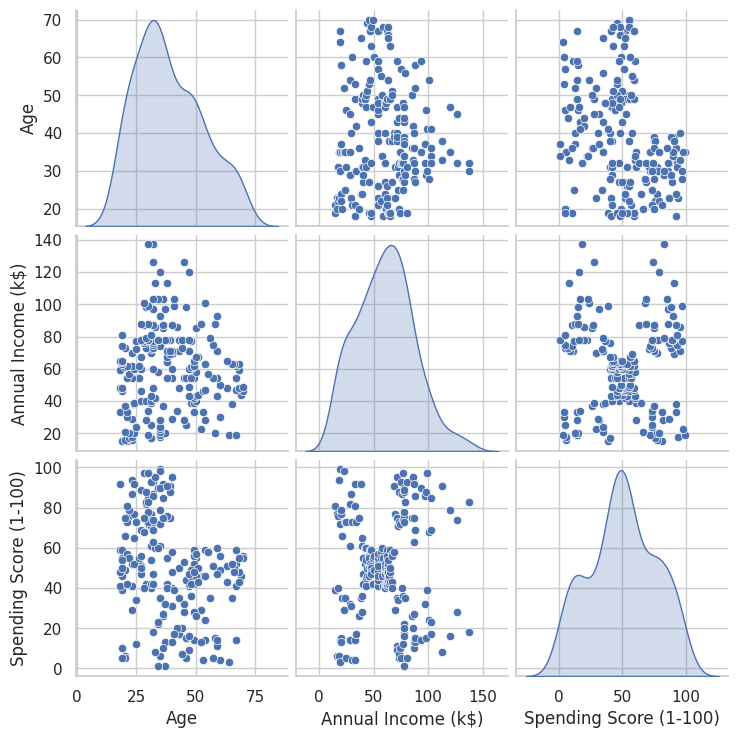

In [27]:
# Cell: Pairwise relationships (numeric only)
sns.pairplot(df[num_cols], diag_kind="kde")
plt.show()

# - Pairplot of three variables: Age, Annual Income (k$), and Spending Score (1–100).
# - Diagonal plots show KDE distributions:
#   - Age: unimodal, centered around late 20s–40s, tailing into 60s.
#   - Income: roughly normal around ~60k with tails toward 15k and 140k.
#   - Spending Score: broad, slightly bimodal around ~30–40 and ~70–80.
# - Age vs Income: weak relationship; all ages spread across incomes, slight concentration around 20–40 years and 40–80k income.
# - Age vs Spending: younger customers show both very high and very low spending; older customers tend to mid–low spending.
# - Income vs Spending: no strong linear trend; clusters suggest segmentable groups (e.g., low income–high spend, high income–low spend, mid income–mid spend).
# - Scatter points are jittered with gridlines; density of points higher in mid ranges.
# - Overall: variables are not strongly linearly correlated; data likely suitable for clustering/segmentation rather than simple regression.


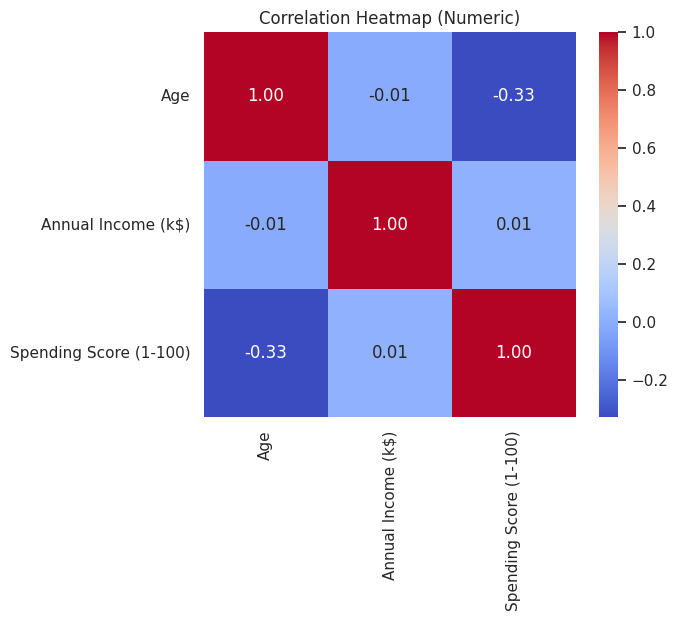

In [28]:
# Cell: Correlation heatmap (numeric)
plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric)")
plt.show()

## Correlation heatmap: quick recall comments

# - Matrix shows Pearson correlations among Age, Annual Income(k$), and Spending Score(1–100); diagonal is 1.00 by definition.[1]
# - Age vs Spending Score ≈ −0.33: moderate negative linear relationship—older customers tend to have lower spending scores.[2][3][1]
# - Age vs Annual Income ≈ −0.01: essentially no linear relationship—income is spread across ages.[4][1]
# - Income vs Spending Score ≈ 0.01: no meaningful linear relationship—spending score doesn’t track income here.[4][1]
# - Color scale: red=positive, blue=negative; darker intensity means stronger absolute correlation.[5]
# - Takeaway: weak-to-moderate correlations suggest clustering/segmentation may be more informative than simple linear models on these variables.[6][7]



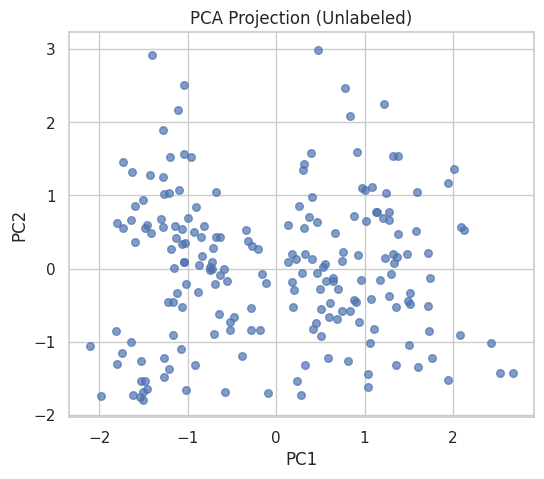

In [29]:
# Cell: PCA for visualization (2D projection only)

# PCA (Principal Component Analysis) is a dimensionality reduction method that transforms correlated
# variables into a smaller set of uncorrelated variables,
# called principal components, that capture the maximum variance in the data.

# PC1 (the first principal component) is the single direction through the data that captures the largest possible variance; it represents the most informative axis of variation.

# PC2 (the second principal component) is the next-most-informative direction, constrained to be orthogonal to PC1 and capturing the largest remaining variance after PC1

# Practically,
# PCA helps visualize high-dimensional data, reduce noise and multicollinearity,
# and prepare inputs for downstream models while retaining most of the information.

pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_vis = pca_vis.fit_transform(X)
plt.figure(figsize=(6,5))
plt.scatter(X_pca_vis[:,0], X_pca_vis[:,1], s=30, alpha=0.7)
plt.title("PCA Projection (Unlabeled)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


# - Plot: 2D PCA scatter of unlabeled data points; axes are PC1 (x) and PC2 (y).
# - Each dot is a sample projected onto first two principal components; no class/color labels.
# - Spread is roughly elliptical, centered near (0, 0) with moderate variance along both PCs.
# - PC1 range ≈ −2.5 to +2.5; PC2 range ≈ −2.0 to +3.0.
# - Slight denser concentration around PC1 ∈ [−0.5, 1.0] and PC2 ∈ [−1.0, 1.0].
# - No obvious well-separated clusters; possible mild substructures but overlapping.
# - Gridlines and semi-transparent markers aid density perception; points show mild rightward skew on PC1.
# - Interpretation: Top two PCs capture main variance directions; useful for visualization and as input to clustering, but labels needed to assess class separability.



In [30]:
# @title Baseline K-Means (Default Parameters)

## Run K-Means with a nominal k (e.g., 5) to preview structure, then refine via k selection

# Cell: Baseline K-Means (k=5 as a quick start)
# Initialize a baseline KMeans clustering model
# - n_clusters=5: cluster the data into 5 groups
# - random_state ensures reproducibility of cluster assignments
# - n_init="auto": automatically selects the number of initializations for better convergence
kmeans_baseline = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init="auto")

# Fit the KMeans model on the preprocessed data X and predict cluster labels for each sample
labels_base = kmeans_baseline.fit_predict(X)

# Calculate the silhouette score to evaluate clustering quality
# Silhouette score ranges from -1 to 1, where higher is better (cohesion within clusters and separation between clusters)
sil_base = silhouette_score(X, labels_base)

sil_base  # Display the silhouette score of the baseline clustering


##K-Means clustering

# Purpose: partition data into K clusters by assigning points to the nearest centroid and updating centroids iteratively.
# Centroid: the mean of points assigned to a cluster; cluster “center” in feature space.
# Objective: minimize within-cluster sum of squared distances (inertia/SSE); tighter, well-separated clusters yield lower inertia.
# Core loop (Lloyd’s algorithm):
# Assign step (E-step): label each point with nearest centroid (typically Euclidean distance).
# Update step (M-step): recompute each centroid as the mean of its assigned points; repeat until convergence or max_iter.
# Initialization:
# k-means++ picks initial centers probabilistically to speed convergence and improve quality vs random init.
# Multiple restarts (n_init) help avoid poor local minima; keep best run by lowest inertia.
# Choosing K: elbow method inspects inertia vs K for a “bend” as a heuristic starting point.
# Sensitivities: results depend on init, choice of K, scale of features, and outliers; works best for roughly spherical, equal-variance clusters.
# Variants: MiniBatchKMeans for large datasets trades slight accuracy for speed using small batches



## Silhouette score (cluster validity)

# What it measures: how similar a point is to its own cluster (cohesion) vs nearest other cluster (separation).
# Per-point quantities:
# a_i = average distance to points in same cluster (intra-cluster).
# b_i = lowest average distance to points in the nearest other cluster (nearest-cluster).
# Formula (per point): s_i = (b_i − a_i) / max(a_i, b_i), so s_i ∈ [−1, 1].
# Interpretation:
# Close to +1: well clustered, far from other clusters.
# Around 0: on/between cluster boundaries; overlapping clusters.
# Negative: likely misassigned; closer to another cluster than its own.
# Using it: average silhouette across all points summarizes overall clustering quality and helps compare K values; silhouette plots show distribution per cluster.
# Caveats: tends to work best for convex, similar-sized clusters; high scores are harder in high dimensions due to distance concentration.



np.float64(0.2800788749757102)

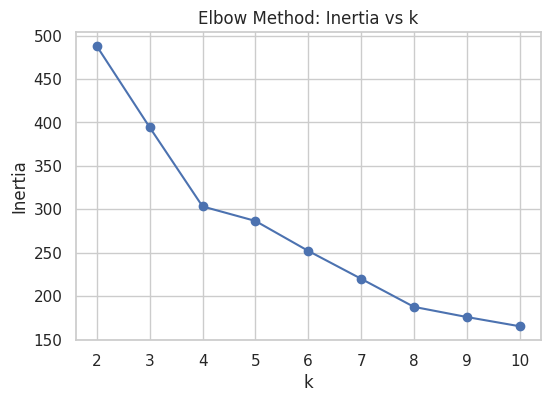

In [31]:
# @title Choosing Optimal k (Elbow + Silhouette)

## Use inertia (Elbow) and silhouette to balance compactness and separation.

# Cell: Elbow method
ks = list(range(2, 11))
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker="o")
plt.title("Elbow Method: Inertia vs k")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.xticks(ks)
plt.show()


## Elbow plot (Inertia vs k) — quick recall comments

# - What it shows: K on x-axis, K-Means inertia/WCSS on y-axis; inertia is sum of squared distances to nearest centroid.[1][2][3]
# - Expected shape: inertia drops quickly at small k, then levels off; diminishing returns after a bend called the “elbow”.[4][5][1]
# - How to read: pick k at the elbow where additional clusters yield only marginal inertia reduction; balances compactness vs model parsimony.[6][1][4]
# - In this plot: steep decreases from k=2→4, slower after k≈6–7; plausible elbows near k≈4 or k≈6 depending on tolerance for added complexity.[2][5][4]
# - Caveats: elbow can be subtle/subjective; inertia always decreases with k and favors spherical, equal-variance clusters—standardize features and corroborate with other metrics.[3][1][2]
# - Next step: validate candidate k values with silhouette score/plots to check separation and confirm choice.[7][8][9]



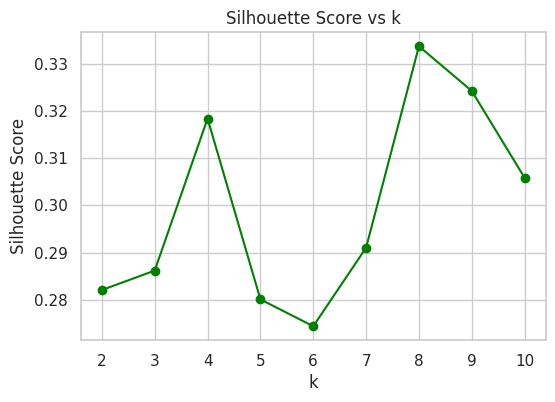

(8, np.float64(0.33367030848687984))

In [32]:
# Cell: Silhouette scores
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker="o", color="green")
plt.title("Silhouette Score vs k")
plt.xlabel("k"); plt.ylabel("Silhouette Score")
plt.xticks(ks)
plt.show()

best_k = ks[int(np.argmax(sil_scores))]
best_k, max(sil_scores)

# - Plot type: Silhouette Score vs number of clusters k for K-Means.
# - Axes: x=k (2–10); y=average silhouette score (−1 to 1, here ~0.27–0.34).
# - Peak quality: best score at k=8 (~0.334) → most separated/cohesive clusters among tested k.
# - Secondary candidates: k=9 (~0.325) and k=4 (~0.318) also decent; k=10 (~0.306) starts to decline.
# - Weak regions: k=5–6 dip (~0.27–0.28) → poorer clustering; possible overlap or misassignments.
# - Interpretation rule: choose k that maximizes silhouette; also prefer simpler model if scores are close (e.g., k=8 best, but k=4 could be acceptable with fewer clusters).
# - Actionables: inspect silhouette plot per cluster for k=8 and k=4; verify cluster sizes/boundaries and domain usefulness.



In [36]:
# @title Final K-Means Model and Visualization

## Train with optimal k and visualize clusters in PCA space; interpret centroids and segment themes

# Cell: Train final K-Means
kmeans_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init="auto")
final_labels = kmeans_final.fit_predict(X)
df_clusters = df.copy()
df_clusters["cluster"] = final_labels
df_clusters.tail()


,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
195,Female,35,120,79,1
196,Female,45,126,28,3
197,Male,32,126,74,1
198,Male,32,137,18,7
199,Male,30,137,83,1


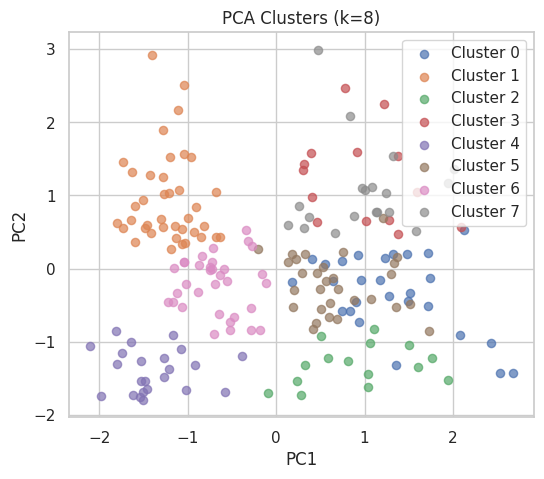

In [37]:
# Cell: PCA 2D cluster plot
plt.figure(figsize=(6,5))
for c in np.unique(final_labels):
    idx = final_labels == c
    plt.scatter(X_pca_vis[idx,0], X_pca_vis[idx,1], s=35, alpha=0.7, label=f"Cluster {c}")
plt.title(f"PCA Clusters (k={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()

# - Plot: PCA scatter with K-Means clustering results for k=8; axes are PC1 (x) and PC2 (y), the first two principal components.
# - Points: each dot is a sample projected to PC1–PC2 and colored by its assigned cluster label (0–7); legend maps colors to cluster IDs.
# - Structure: clusters occupy different regions with some overlap; several compact groups around PC1≈[−1.5,0.5], PC2≈[−1.5,0.5], and distinct bands near PC2>1.
# - Separation: some clusters are well separated vertically (PC2 dimension), while a few overlap along PC1 around 0.5–1.5 indicating potential boundary ambiguity.
# - Spread: clusters 2/4 (green/purple) show larger vertical spread (PC2 variance), whereas clusters like 5/7 (brown/pink) are tighter.
# - Use: visualize how k=8 partitions the PCA space; helpful to inspect centroids, sizes, and silhouette scores to confirm quality and consider merging overlapping groups.



In [38]:
# Cell: Centroid analysis (in original feature space)

# Extract cluster centroids from the final trained KMeans model
# These centroids are in the transformed (scaled and one-hot encoded) feature space
centroids_transformed = kmeans_final.cluster_centers_

# Create a DataFrame for centroids with columns named after the transformed features
centroids_df = pd.DataFrame(centroids_transformed, columns=feature_names)

# To interpret numeric features in their original scale, we inverse-transform the numeric part of centroids
# Extract the scaler from the numeric preprocessing pipeline to perform inverse scaling
num_scaler = preprocessor.named_transformers_["num"].named_steps["scaler"]

# Identify the indices corresponding to numeric features within the transformed feature set
num_indices = list(range(len(num_cols)))

# Extract numeric centroid values from transformed centroids DataFrame
num_centroids = centroids_df.iloc[:, num_indices].values

# Apply inverse scaling to convert numeric centroid coordinates back to their original scale
num_centroids_original = num_scaler.inverse_transform(num_centroids)

# Create a new DataFrame with numeric centroids in original units, named by the original numeric columns
centroids_original = pd.DataFrame(num_centroids_original, columns=num_cols)

# Add a column indicating the cluster label for each centroid
centroids_original["cluster"] = range(centroids_original.shape[0])

# Display the numeric centroids in original scale alongside their cluster IDs
centroids_original


,Age,Annual Income (k$),Spending Score (1-100),cluster
0,58.148,48.889,40.148,0
1,32.692,86.538,82.128,1
2,40.800,25.933,21.133,2
3,43.786,93.286,20.643,3
4,25.000,25.261,77.609,4
5,52.133,55.667,48.433,5
6,25.152,55.727,49.667,6
7,38.474,85.895,14.211,7


**Interpretation tips:**

Higher Annual Income + higher Spending Score typically marks premium segments; lower income + moderate score can be discount-sensitive segments.

Gender one-hot means interpret cluster averages on encoded columns cautiously (proportions across categories).

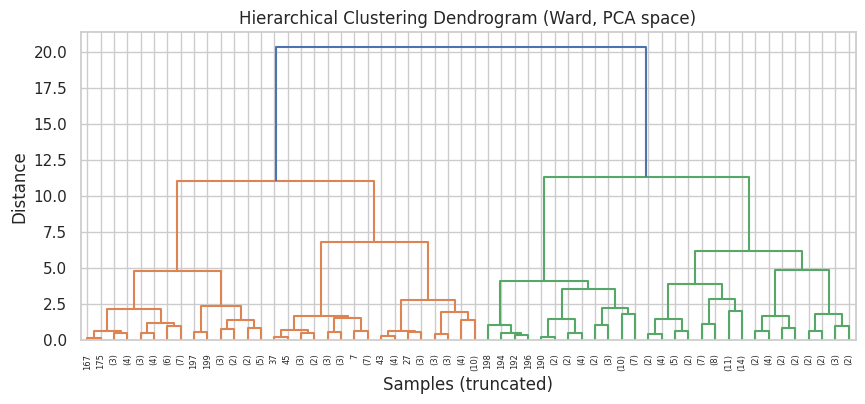

In [39]:
# @title Hierarchical Clustering + Dendrogram

## Agglomerative clustering to compare with K-Means; show dendrogram and 2D cluster scatter

# Cell: Dendrogram using linkage on PCA-reduced space for readability
Z = linkage(X_pca_vis, method="ward")
plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode="level", p=5, color_threshold=None)
plt.title("Hierarchical Clustering Dendrogram (Ward, PCA space)")
plt.xlabel("Samples (truncated)"); plt.ylabel("Distance")
plt.show()



In [40]:
# Cell: Agglomerative clustering with n_clusters = best_k (for comparison)
agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
agg_labels = agg.fit_predict(X)

sil_agg = silhouette_score(X, agg_labels)
sil_agg


np.float64(0.3160060283896421)

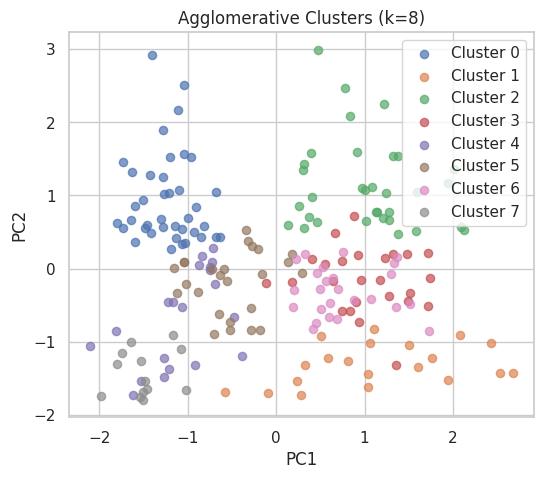

In [41]:
# Cell: PCA 2D plot - Agglomerative
plt.figure(figsize=(6,5))
for c in np.unique(agg_labels):
    idx = agg_labels == c
    plt.scatter(X_pca_vis[idx,0], X_pca_vis[idx,1], s=35, alpha=0.7, label=f"Cluster {c}")
plt.title(f"Agglomerative Clusters (k={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()


In [43]:
#  @title Cluster Interpretation for Business

# Approach:

# Use centroids_original (numeric) to name segments by spend/income/age patterns.

# Summarize per-cluster stats to build personas.

# Cell: Per-cluster summary statistics
# Build aggregation dictionary for numerical columns with mean and median
agg_dict = {col: ["mean", "median"] for col in num_cols}

# If categorical columns exist, add their aggregation using 'value_counts'
if len(cat_cols) > 0:
    agg_dict.update({col: "value_counts" for col in cat_cols})

# Perform groupby aggregation on 'cluster' column using the constructed agg_dict
summary = df_clusters.groupby("cluster").agg(agg_dict)

summary



Age        Annual Income (k$)        Spending Score (1-100)  \
              mean median               mean median                   mean   
0           58.148 59.000             48.889 54.000                 40.148   
1           32.692 32.000             86.538 79.000                 82.128   
2           40.800 40.000             25.933 25.000                 21.133   
3           43.786 44.000             93.286 92.500                 20.643   
4           25.000 23.000             25.261 24.000                 77.609   
5           52.133 50.000             55.667 55.500                 48.433   
6           25.152 25.000             55.727 58.000                 49.667   
7           38.474 40.000             85.895 81.000                 14.211   
(0, Male)      NaN    NaN                NaN    NaN                    NaN   
(1, Female)    NaN    NaN                NaN    NaN                    NaN   
(1, Male)      NaN    NaN                NaN    NaN                    NaN   
(2, Female)    NaN    NaN                NaN    NaN                    NaN   
(2, Male)      NaN    NaN                NaN    NaN                    NaN   
(3, Female)    NaN    NaN                NaN    NaN                    NaN   
(4, Female)    NaN    NaN                NaN    NaN                    NaN   
(4, Male)      NaN    NaN                NaN    NaN                    NaN   
(5, Female)    NaN    NaN                NaN    NaN                    NaN   
(6, Female)    NaN    NaN                NaN    NaN                    NaN   
(6, Male)      NaN    NaN                NaN    NaN                    NaN   
(7, Male)      NaN    NaN                NaN    NaN                    NaN   

                         Gender  
            median value_counts  
0           46.000          NaN  
1           83.000          NaN  
2           17.000          NaN  
3           21.000          NaN  
4           77.000          NaN  
5           48.500          NaN  
6           51.000          NaN  
7           13.000          NaN  
(0, Male)      NaN       27.000  
(1, Female)    NaN       21.000  
(1, Male)      NaN       18.000  
(2, Female)    NaN       13.000  
(2, Male)      NaN        2.000  
(3, Female)    NaN       14.000  
(4, Female)    NaN       13.000  
(4, Male)      NaN       10.000  
(5, Female)    NaN       30.000  
(6, Female)    NaN       21.000  
(6, Male)      NaN       12.000  
(7, Male)      NaN       19.000

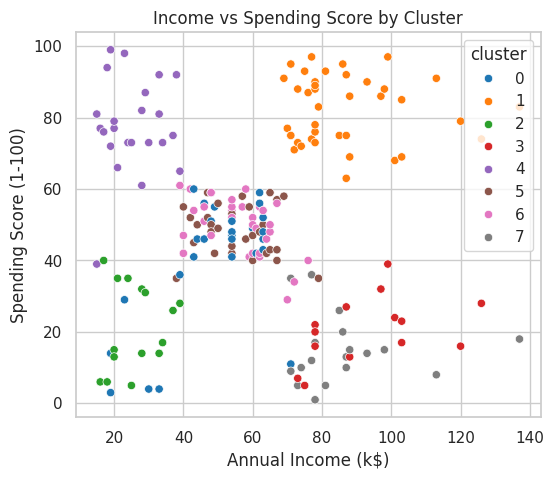

In [44]:
# Cell: Quick labeled scatter for two key features (if present)
if "Annual Income (k$)" in df.columns and "Spending Score (1-100)" in df.columns:
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df_clusters, x="Annual Income (k$)", y="Spending Score (1-100)", hue="cluster", palette="tab10")
    plt.title("Income vs Spending Score by Cluster")
    plt.show()


##Interpretation guidance:

# High income, high spending: loyalty and premium experiences.
# High income, low spending: activation strategies, product fit.
# Low income, high spending: discount bundles, retention watch.
# Demographic splits (e.g., Gender) can guide creative and channel strategy.


**Evaluation and Limitations**

Internal metrics like silhouette do not guarantee business value; consider A/B testing campaigns by cluster.

K-Means assumes convex/spherical clusters and is sensitive to scaling and outliers; agglomerative is more flexible but can be costlier.

PCA plots are low-dimensional projections—cluster separability may differ in high-D space.

Validate clusters via stability checks, expert review, and downstream KPIs (CTR, AOV, conversion lift)

In [45]:
# @title Save Pipeline + K-Means Model

# Cell: Build end-to-end inference pipeline and persist
inference_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("kmeans", kmeans_final)
])

# Fit on the original df to freeze the pipeline state
inference_pipeline.fit(df)

os.makedirs("artifacts", exist_ok=True)
joblib.dump(inference_pipeline, "artifacts/model.pkl")

# Save metadata/config
meta = {
    "features": list(df.columns),
    "categorical": cat_cols,
    "numerical": num_cols,
    "best_k": int(best_k),
    "random_state": RANDOM_STATE
}
with open("artifacts/metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

